Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

Import Data

In [2]:
df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-10-22,6036.660156,6076.259766,5792.339844,6008.419922,6008.419922,2034630016
1,2017-10-23,6006.000000,6075.589844,5732.470215,5930.319824,5930.319824,2401840128
2,2017-10-24,5935.520020,5935.520020,5504.180176,5526.640137,5526.640137,2735699968
3,2017-10-25,5524.600098,5754.330078,5397.879883,5750.799805,5750.799805,1966989952
4,2017-10-26,5747.950195,5976.799805,5721.220215,5904.830078,5904.830078,1905040000


``We Are Only Interested In Closing Prices And Dates, So Let's Fix That``

## EDA

In [3]:
df.shape

(1827, 7)

Dropping Irrelevant Columns

In [4]:
df.drop(["Open","High","Low", "Adj Close", "Volume"], inplace=True, axis=1)
df

,Date,Close
0,2017-10-22,6008.419922
1,2017-10-23,5930.319824
2,2017-10-24,5526.640137
3,2017-10-25,5750.799805
4,2017-10-26,5904.830078
...,...,...
1822,2022-10-18,19334.416016
1823,2022-10-19,19139.535156
1824,2022-10-20,19053.740234
1825,2022-10-21,19172.468750


Making The Date Column Our Index And Normalizing Values

In [5]:
dates = df["Date"]
# Converting Dates To Numbers
normalized_dates = []
for i in dates:
    normalized_dates.append(round(((pd.to_datetime(i).year-2017)+(pd.Period(i).dayofyear/365)),3))
df_norm = pd.DataFrame(data=df["Close"].values, index=normalized_dates, columns=["Close"])
df_norm

,Close
0.808,6008.419922
0.811,5930.319824
0.814,5526.640137
0.816,5750.799805
0.819,5904.830078
...,...
5.797,19334.416016
5.800,19139.535156
5.803,19053.740234
5.805,19172.468750


Plotting Data

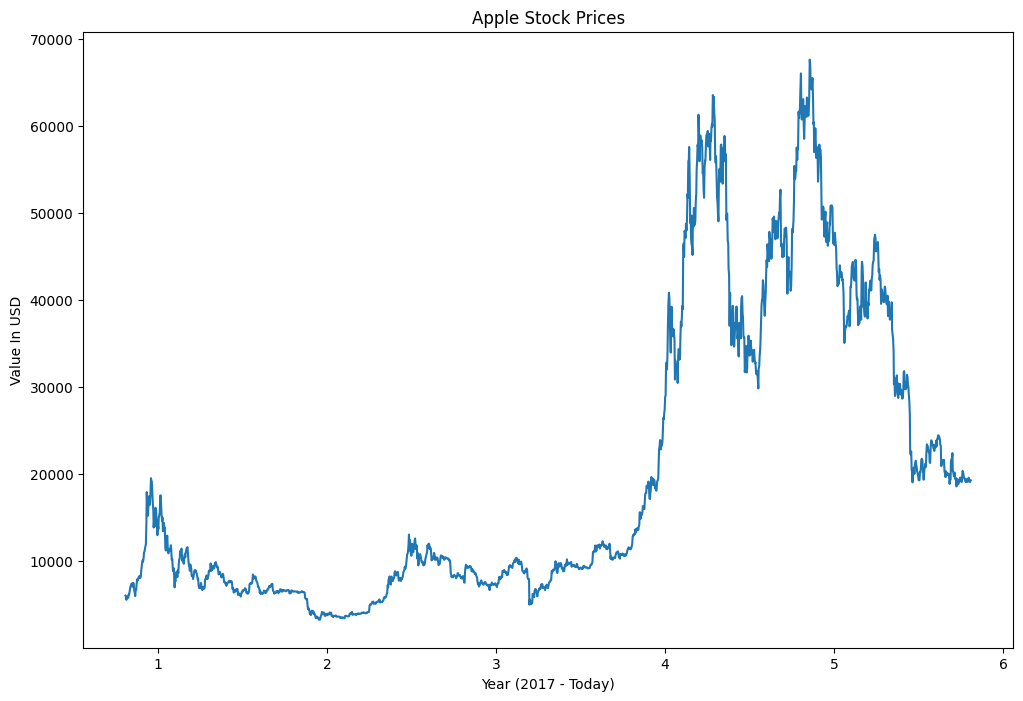

In [6]:
plt.figure(figsize=(12,8))
plt.plot(df_norm)
plt.xlabel("Year (2017 - Today)")
plt.ylabel("Value In USD")
plt.title("Apple Stock Prices")
plt.show()

Scaling Our Data, Inserting Into 

In [7]:
scaler = MinMaxScaler()
norm_close_val = scaler.fit_transform(df_norm)
norm_close_val
df_norm["Close"] = norm_close_val
num_df = np.array(norm_close_val)
df_norm

,Close
0.808,0.043085
0.811,0.041871
0.814,0.035596
0.816,0.039080
0.819,0.041475
...,...
5.797,0.250235
5.800,0.247206
5.803,0.245872
5.805,0.247718


In [8]:
import pickle

def scaler_pickling(scaler, file_name):
    import pickle
    with open(file_name, "wb") as f:
        pickle.dump(scaler, f)

In [9]:
scaler_pickling(scaler, "flask_app/website/static/byte_models/bitcoin_scaler.pkl")

Splitting to training, testing and validation sets
train set: 0.70
test set: 0.20
val set: 0.10

In [8]:
total_len = len(num_df)-365
train_test_val = np.around([total_len * 0.7, total_len * 0.1, total_len * 0.2], decimals=0)
train_test_val = [int(i) for i in train_test_val]
train_test_val

[1023, 146, 292]

train set = 626
val set = 89
test set = 179

Our Time Step Will Be 365 Days

In [9]:
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []
time_step = 365
for i in range(time_step, len(num_df)):
    # Train Set
    if i < time_step + train_test_val[0]:
        X_train.append(num_df[i-time_step:i,0])
        y_train.append(num_df[i,0])
    elif time_step + train_test_val[0] <= i < time_step + train_test_val[0] + train_test_val[1]:
        X_val.append(num_df[i-time_step:i,0])
        y_val.append(num_df[i,0])
    else:
        X_test.append(num_df[i-time_step:i,0])
        y_test.append(num_df[i,0])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)
    
        

In [10]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

1023
146
293


Checking Our Shapes

In [11]:
X_train.shape

(1023, 365)

We Want Our Shape To Be (x,x,1) for X
and (x,1) for y

In [12]:
# For Train Sets
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], 1)
print("X Train Shape:",X_train.shape, "| y Train Shape:", y_train.shape)


X Train Shape: (1023, 365, 1) | y Train Shape: (1023, 1)


In [13]:
# For val Sets
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], 1)
print("X val Shape:",X_val.shape, "| y val Shape:", y_val.shape)

X val Shape: (146, 365, 1) | y val Shape: (146, 1)


In [14]:
# For test Sets
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], 1)
print("X test Shape:",X_test.shape, "| y test Shape:", y_test.shape)

X test Shape: (293, 365, 1) | y test Shape: (293, 1)


Our Sets Are Ready Time To Set Up Our Model

In [15]:
regressor = Sequential()

regressor.add(LSTM(units=180, return_sequences=True, input_shape=(X_train.shape[1],1)))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units=365, return_sequences=True))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units=180, return_sequences=True))
# regressor.add(Dropout(0.2))
regressor.add(LSTM(units=180, return_sequences=False))
regressor.add(Dense(25))
regressor.add(Dense(1))

Compiling Using Adam

In [16]:
regressor.compile(optimizer=Adam(learning_rate=0.0026), loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])

#### Summary

In [17]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 365, 180)          131040    
                                                                 
 lstm_1 (LSTM)               (None, 180)               259920    
                                                                 
 dense (Dense)               (None, 25)                4525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 395,511
Trainable params: 395,511
Non-trainable params: 0
_________________________________________________________________


Plotting Model Structure

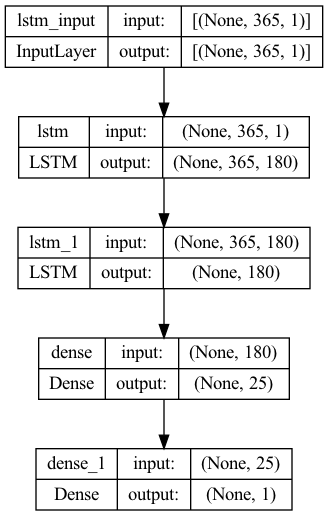

In [18]:
tf.keras.utils.plot_model(regressor, show_shapes=True)

Training The Model

In [19]:
hist = regressor.fit(X_train,
                     y_train,
                     validation_data=(X_val, y_val),
                     epochs=10)
                     #callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=0))

Epoch 1/10


2022-10-25 11:33:46.625080: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


32/32 [==============================] - 21s 587ms/step - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0484
Epoch 2/10
32/32 [==============================] - 19s 601ms/step - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0420
Epoch 3/10
32/32 [==============================] - 20s 619ms/step - loss: 7.4514e-04 - root_mean_squared_error: 0.0273 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0710
Epoch 4/10
32/32 [==============================] - 20s 625ms/step - loss: 8.7518e-04 - root_mean_squared_error: 0.0296 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0424
Epoch 5/10
32/32 [==============================] - 20s 633ms/step - loss: 6.2478e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0404
Epoch 6/10
32/32 [==============================] - 20s 628ms/step - loss: 6.3353e-04 - root_mean_squared_error: 0.0252 - val_loss: 0.

Plotting Loss Over Time

<AxesSubplot:>

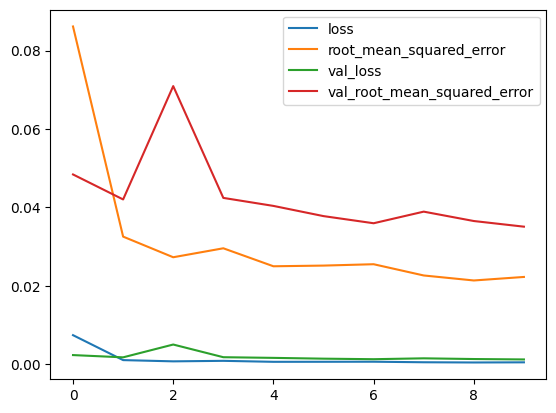

In [20]:
pd.DataFrame(hist.history).plot()

Predicting Baseline (train data)

32/32 [==============================] - 6s 189ms/step


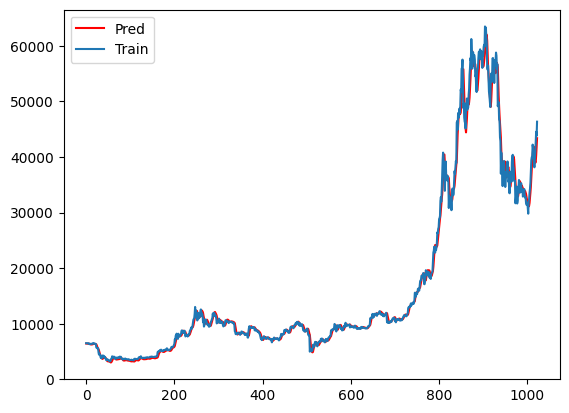

In [21]:
y_train_pred = scaler.inverse_transform(regressor.predict(X_train))
y_train_true = scaler.inverse_transform(y_train)
plt.plot(y_train_pred, 'r')
plt.plot(y_train_true)
plt.legend(["Pred","Train"])
plt.show()

Test Prediction

10/10 [==============================] - 2s 170ms/step


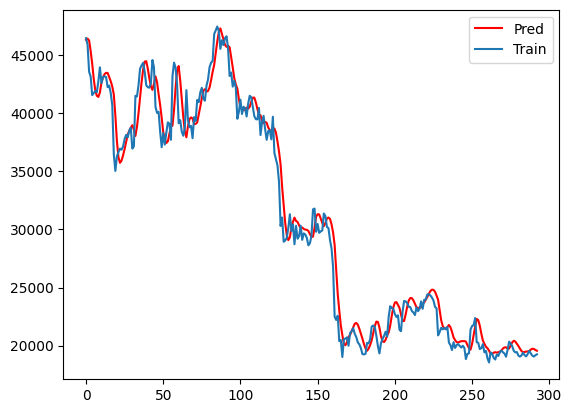

In [22]:
y_test_pred = scaler.inverse_transform(regressor.predict(X_test))
y_test_true = scaler.inverse_transform(y_test)
plt.plot(y_test_pred, 'r')
plt.plot(y_test_true)
plt.legend(["Pred","Train"])
plt.show()

R2 Score For Model

In [23]:
np.round(r2_score(y_test_true, y_test_pred),decimals=2)

0.98

98% Accuracy For The Model IS An Amaing Result

Creating a pickled version

pickling function

In [24]:
import pickle

def file_pickling(model, file_name):
    import pickle
    with open(file_name, "wb") as f:
        pickle.dump(model, f) 

In [25]:
file_pickling(regressor, "byte_models/bitcoin_usd.pkl")

INFO:tensorflow:Assets written to: ram://30d96d14-cc12-4f1b-a48c-03e8766fc56e/assets


INFO:tensorflow:Assets written to: ram://30d96d14-cc12-4f1b-a48c-03e8766fc56e/assets
